## Machine Learning

* For the machine learning of this project, my aim is to predict PISA score averages given the features like GDP, world region, income level, expected school years, gender inequality etc.


* I will try different models, namely: K nearest neighbours, decision tree, XGBoost regression. I will also try changing their parameters to see if I can get a lower MSE / RMSE.

* I will do predictions not classification, so regressors of said models will be used.
* At the end I will compare these scores with each other to find the model that best predicts the PISA scores from my dataset.

In [115]:
#importing libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import metrics

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import xgboost as xgb
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, KFold, LeaveOneOut, cross_val_predict

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error



# Settings
sns.set(style="whitegrid")


## Preparing Dataset for ML
* Encode catagorical variables
* Prepare a data frame for features.

In [116]:
import pandas as pd
df = pd.read_csv('complete_data.csv')

# one hot encoding for income level classification, updated from recit 10
df_income = pd.get_dummies(df['classification'], prefix='classification', drop_first = False)

df = pd.concat([df, df_income], axis=1) # add encoded variables to original data frame

# one hot encoding for world reagions
df_region = pd.get_dummies(df['World_Region'], prefix='World_Region', drop_first = False)

df = pd.concat([df, df_region], axis=1)

# catagorical variables to exclude from standardization
exclude = list(df_income) + list(df_region)
print(exclude)

# unused columns for ML are dropped for clarity
#df now has all features and the target column, including encoded categorical variables
df = df.drop(columns=[
    "Entity",
    "classification",
    "World_Region",
    "Population",

    "Math_PISA_Female",
    "Math_PISA_Male",
    "Math_PISA_Total",

    "Read_PISA_Female",
    "Read_PISA_Male",
    "Read_PISA_Total",

    "Sci_PISA_Female",
    "Sci_PISA_Male",
    "Sci_PISA_Total" ,


    'PISA_Girls_Average',
    'PISA_Boys_Average',

    'Mean_School_Years_M',
    'Mean_School_Years_F',
    'Unnamed: 0'])

df = df * 1 # used to convert boolean to integer

X = df.drop(columns = 'PISA_Total_Average') # all features are put into a new dataframe X
y = df['PISA_Total_Average'] # target value PISA_Total_Average is put into new dataframe y

# seperate dataframes to be used in ML models is now prepared

print(y.head())

df.to_csv("complete_data_encoded.csv")

X.head()

['classification_High-income countries', 'classification_Low-income countries', 'classification_Lower-middle-income countries', 'classification_Upper-middle-income countries', 'World_Region_Africa', 'World_Region_Asia', 'World_Region_Europe', 'World_Region_North America', 'World_Region_Oceania', 'World_Region_South America']
0    372.335440
1    376.331782
2    380.328124
3    384.324467
4    395.222270
Name: PISA_Total_Average, dtype: float64


,Year,EduSpend_GDP,GDP_PPP_perCapita,Gini_Coefficient,Gender_Inequality,GovEduSpend_Pct,Avg_School_Years,Expected_School_Years,HDI,Corruption_Index,classification_High-income countries,classification_Low-income countries,classification_Lower-middle-income countries,classification_Upper-middle-income countries,World_Region_Africa,World_Region_Asia,World_Region_Europe,World_Region_North America,World_Region_Oceania,World_Region_South America
0,2000,3.430170,6600.9785,0.301628,0.292,11.371651,8.754172,10.70049,0.678,0.740,0,0,1,0,0,0,1,0,0,0
1,2003,3.138230,8014.0366,0.313579,0.275,11.371651,8.953132,11.37575,0.701,0.745,0,0,1,0,0,0,1,0,0,0
2,2006,3.191460,9598.6460,0.303920,0.256,10.767986,9.147308,12.55426,0.728,0.722,0,0,1,0,0,0,1,0,0,0
3,2009,3.461151,11553.8210,0.297286,0.191,11.138222,9.451740,13.36020,0.752,0.756,0,0,0,1,0,0,1,0,0,0
4,2012,3.309061,12577.7560,0.289605,0.196,11.626995,10.025110,15.76571,0.789,0.765,0,0,0,1,0,0,1,0,0,0


* World regions and income levels catagorical variables are converted using one hot encoding.

  * Since I only have 4 income levels and 6 world regions, one hot encoding or dummy variable approach can be used. Label encoding could be better if there were too many catagories, but it is not the case here.

  * For regression dummy variable approach can be used to have a meaningful intercept, but for models such as KNN, XGBoost and Random Forest I will use one hot encoding.



* Data frame containing the features and target value is prepared.
 * Catagorical ones are one hot or target encoded.

## K-Nearest Neighbours Regression

* If features are not standardized, then larger scaled values will affect the results more than the smaller scaled values when finding the nearest neighbours. Because of this reason, before features are used, they are standardized for KNN.  

* Target value PISA scores will be kept as is.

MSE for k = 5, ..., 8:
  k = 5: MSE = 676.412, RMSE = 26.008
  k = 6: MSE = 710.845, RMSE = 26.662
  k = 7: MSE = 727.382, RMSE = 26.970
  k = 8: MSE = 756.822, RMSE = 27.510
Best k: 1
 MSE at best k: 468.330
 RMSE at best k: 21.641


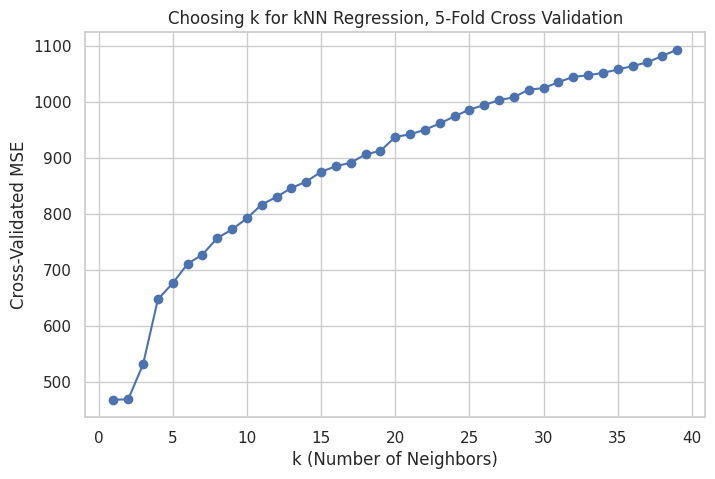

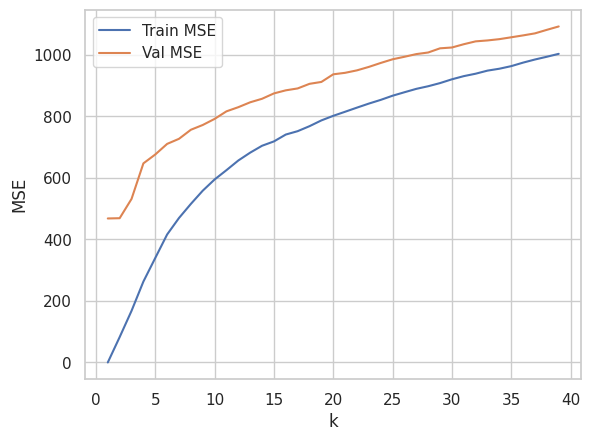

In [117]:
k_values = list(range(1, 40))
cv_mse = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for k in k_values:
    fold_mse = []

    # looping over 5 folds for cross validation
    for train_idx, test_idx in kf.split(X):

        X_train = X.iloc[train_idx]
        X_test  = X.iloc[test_idx]
        y_train = y.iloc[train_idx]
        y_test  = y.iloc[test_idx]


        # first scaler is fitted on train only, then that is used to scale test
        # this is done to avoid overfitting, if standardization is done as a whole CV does not work as expected
        scaler = StandardScaler().fit(X_train)
        X_tr_scaled = scaler.transform(X_train)
        X_te_scaled = scaler.transform(X_test)

        # training and prediction
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_tr_scaled, y_train)
        y_pred = knn.predict(X_te_scaled)

        # computing MSE for this fold
        fold_mse.append(np.mean((y_pred - y_test)**2))

    # average over folds
    cv_mse.append(np.mean(fold_mse))

print("MSE for k = 5, ..., 8:")
for k in range(5, 9):
    idx = k_values.index(k)
    rmse1= cv_mse[idx]**0.5
    print(f"  k = {k}: MSE = {cv_mse[idx]:.3f}, RMSE = {rmse1:.3f}")


# picking the best k
best_k   = k_values[np.argmin(cv_mse)]
best_mse = cv_mse[np.argmin(cv_mse)]
best_rmse = np.sqrt(best_mse)

print(f"Best k: {best_k}")
print(f" MSE at best k: {best_mse:.3f}")
print(f" RMSE at best k: {best_rmse:.3f}")




# Plot k vs MSE, from recit 12
plt.figure(figsize=(8, 5))
plt.plot(k_values, cv_mse, marker='o')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Cross-Validated MSE")
plt.title("Choosing k for kNN Regression, 5-Fold Cross Validation")
plt.grid(True)
plt.show()

# plotting train and test MSE's to see if k=1 overfits
train_mse = []
val_mse   = []

for k in k_values:
    fold_train = []
    fold_val   = []
    for train_idx, test_idx in kf.split(X):
        # spliting and scaling like above code
        X_train = X.iloc[train_idx]
        X_test  = X.iloc[test_idx]
        y_train = y.iloc[train_idx]
        y_test  = y.iloc[test_idx]
        scaler = StandardScaler().fit(X_train)
        X_tr = scaler.transform(X_train)
        X_te = scaler.transform(X_test)

        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_tr, y_train)

        # training error
        y_tr_pred = knn.predict(X_tr)
        fold_train.append(np.mean((y_tr_pred - y_train)**2))

        # validation error
        y_te_pred = knn.predict(X_te)
        fold_val.append(np.mean((y_te_pred - y_test)**2))

    train_mse.append(np.mean(fold_train))
    val_mse.append(np.mean(fold_val))

# plotting both curves:
plt.plot(k_values, train_mse, label="Train MSE")
plt.plot(k_values, val_mse,   label="Val MSE")
plt.legend(); plt.xlabel("k"); plt.ylabel("MSE"); plt.show()


* When different number of neighboors are compared, k=1 gives the lowest MSE. But there is a risk of overfitting if k is picked as 1.

> MSE at k=1: 468.330  
> RMSE at best k=1: 21.641

* Therefore, I plotted another graph to see how different train and validation MSE's are.  
 * As seen in the graph, MSE is ~0 for k=1 in training set and around 300 for validation set. This means there is overfitting.  
 * Because of this even though k=1 lowers the MSE, it looks better to choose k around 5 to 8.

> MSE for k = 5, ..., 8:  
>  k = 5: MSE = 676.412, RMSE = 26.008   
>  k = 6: MSE = 710.845, RMSE = 26.662  
>  k = 7: MSE = 727.382, RMSE = 26.970  
>  k = 8: MSE = 756.822, RMSE = 27.510  

* From these 6 could be chosen to reduce overfitting while getting a relatively lower MSE/RMSE.

## Decision Tree

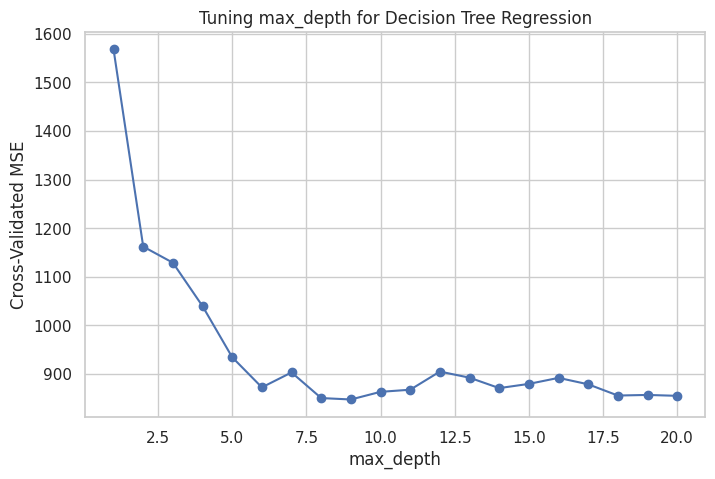

Best max_depth: 9
MSE at best depth: 847.882
RMSE at best depth: 29.118

Average MSE for max_depth=6:  872.777 
Average RMSE for max_depth=6:  29.543 


In [118]:
depths = list(range(1, 21))
cv_scores = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# updated from recit 12
for d in depths:
    tree = DecisionTreeRegressor(max_depth=d, random_state=1)
    scores = cross_val_score(tree, X, y, cv=kf, scoring='neg_mean_squared_error')
    cv_scores.append(-scores.mean())

# Plot
plt.figure(figsize=(8, 5))
plt.plot(depths, cv_scores, marker='o')
plt.xlabel("max_depth")
plt.ylabel("Cross-Validated MSE")
plt.title("Tuning max_depth for Decision Tree Regression")
plt.grid(True)
plt.show()

best_index = np.argmin(cv_scores)

best_depth = depths[best_index]
best_mse   = cv_scores[best_index]
best_rmse  = np.sqrt(best_mse)

print(f"Best max_depth: {best_depth}")
print(f"MSE at best depth: {best_mse:.3f}")
print(f"RMSE at best depth: {best_rmse:.3f}")

print()
tree = DecisionTreeRegressor(max_depth=6, random_state=1)
mse_scores = cross_val_score(tree, X, y, cv=kf, scoring='neg_mean_squared_error')
mse_scores = -mse_scores
mean_mse = mse_scores.mean()
rmse_scores = np.sqrt(mean_mse)

print("Average MSE for max_depth=6: ", f"{mse_scores.mean():.3f} ")

print("Average RMSE for max_depth=6: ", f"{rmse_scores:.3f} ")


* Here is a decision tree with min_samples_leaf = 1, and mean_samples_split = 2, and the graph shows how different max_depth affects the model.

* With these hyperparameters best max_depth is 9. And corresponding MSE and RMSE are as follows:     
 * MSE = 847.882
 * RMSE = 29.118

* Increasing max depth also increases the complexity of the model. Since largest decrease happens before 6. And max_depth = 6 produces very similar results to depth 9, so I will choose 6 as my max depth.

* For max_depth = 6:
 * MSE: 872.777
 * RMSE: 29.543





* I will now try different split and leaf sizes to see if they will improve the predictions.

---

Best hyperparameters found for max_depth = 6:
  min_samples_split= 2
  min_samples_leaf = 7
5-fold CV MSE      = 653.650
5-fold CV RMSE     = 25.567


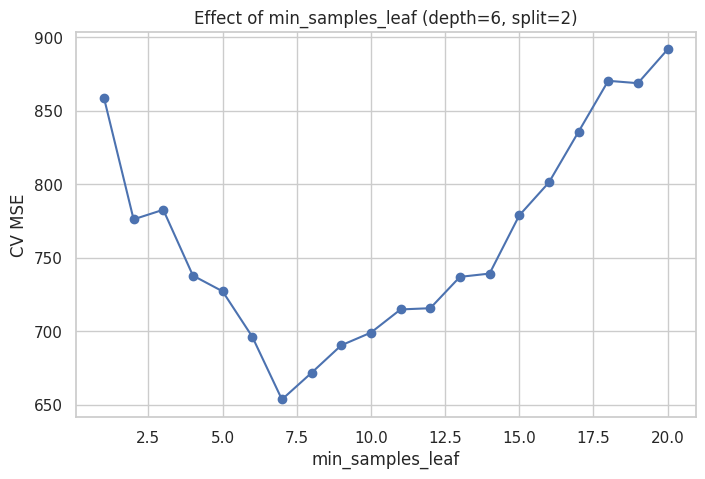

In [119]:
from sklearn.tree import DecisionTreeRegressor

# different values for min_samples_split and min_samples_leaf will be tried to find the best one for max depth = 6
splits = list(range(2, 21)) # splits should be at least 2
leafs = list(range(1, 21))

results = []

kf = KFold(n_splits=5, shuffle=True, random_state=1)

for s in splits:
  for l in leafs:
    tree = DecisionTreeRegressor(
              max_depth=6,
              min_samples_split=s,
              min_samples_leaf=l,
              random_state=42
          )

    scores = cross_val_score(tree, X, y, cv=kf, scoring='neg_mean_squared_error')
    mean_mse = -scores.mean()

    # appending leaf, depth and split number with mean_mse to results list,
    # later it will be compared to find the best
    results.append((s, l, mean_mse))

best_split = -1
best_leaf  = -1
best_mse   = float('inf')  # to start with +∞

for entry in results:
    s, l, mse = entry
    if mse < best_mse:
        best_mse   = mse
        best_split = s
        best_leaf  = l

print("Best hyperparameters found for max_depth = 6:")
print("  min_samples_split=", best_split)
print("  min_samples_leaf =", best_leaf)
print(f"5-fold CV MSE      = {best_mse:.3f}")
print(f"5-fold CV RMSE     = {np.sqrt(best_mse):.3f}")

# ploting MSE vs leaf size at the depth 6 and best split
leaf_sizes = []
mses       = []

for entry in results:
    s, l, mse = entry
    if s == best_split:
        leaf_sizes.append(l)
        mses.append(mse)

plt.figure(figsize=(8,5))
plt.plot(leaf_sizes, mses, marker='o')
plt.xlabel('min_samples_leaf')
plt.ylabel('CV MSE')
plt.title(f'Effect of min_samples_leaf (depth={6}, split={best_split})')
plt.grid(True)
plt.show()


* Choosing min_samples_split = 2 and min_samples_leaf = 7 improved the results further.

* For min_samples_split = 2 and min_samples_leaf = 8 and max_depth = 6:  
  * MSE: 653.65
  * RMSE: 25.567

* These results are better than comparing with only tuning max_depth hyperparameter.

### XGBoost Regression

In [122]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score



xgb = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42
)

# 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

neg_mse_scores  = cross_val_score(xgb, X, y,
                                  scoring='neg_mean_squared_error',
                                  cv=kf,
                                  n_jobs=-1)

mse_scores  = -neg_mse_scores
rmse_scores1 = (mse_scores.mean())**0.5


print("MSE per fold: ", np.round(mse_scores, 2))
print("Mean MSE:     ", np.round(mse_scores.mean(), 2))
print()
print("RMSE per fold:", np.round(rmse_scores, 2))
print("Mean RMSE:    ", np.round(rmse_scores1, 2))

MSE per fold:  [266.63 351.95 545.95 454.79 465.95]
Mean MSE:      417.05

RMSE per fold: [16.33 18.76 23.37 21.33 21.59]
Mean RMSE:     20.42


In [121]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 300, 400,500],
    'max_depth':    [2, 3, 5, 6, 7],
    'learning_rate':[0.01, 0.1, 0.3, 0.35],
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=kf,
    n_jobs=-1,
    verbose= 1 # to print out how many candidates and fits
)

grid.fit(X, y)

print("Best params:", grid.best_params_)
mse = -grid.best_score_
rmse = mse**0.5
print(f"CV MSE (best): {mse:.2f}")
print(f"CV RMSE (best): {rmse:.2f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
CV MSE (best): 371.77
CV RMSE (best): 19.28


* Trying different hyperparameters using grid search improved the results slightly.

  * Default parameters seem to work nearly the same for this model.



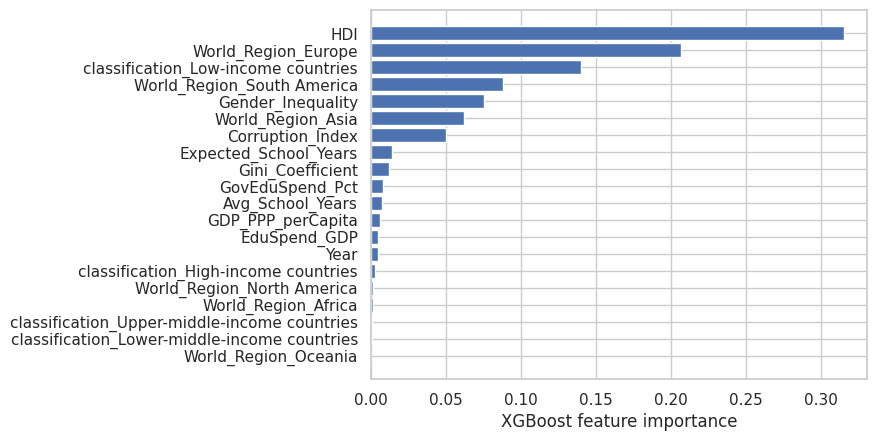

In [123]:
from xgboost import XGBRegressor

xgb = XGBRegressor(eval_metric='rmse', random_state=42, n_jobs=-1)
xgb.fit(X, y)

# plotting the importance of features
sorted_idx = xgb.feature_importances_.argsort()
plt.barh(np.array(X.columns)[sorted_idx],
         xgb.feature_importances_[sorted_idx])
plt.xlabel("XGBoost feature importance")
plt.show()


* HDI score is calculated using 3 features: healthy life, knowledge and decent standard of living. So this feature seems to encapsulate important information for PISA score prediction.   

* Europe contains many high scoring countries so having a huge importance in XGB could be expected.

## Linear regression

### Converting Categorical Variables
* One hot encoding to dummy variable

* Previously, when I prepared my data I used one hot encoding to use for other models.

* For linear regression, intercept is important so I will drop one of the columns for each catagorical variable and get dummy variable instead of one hot encoding.

In [124]:
exclude = list(df_income) + list(df_region)

numerical_columns = []
for column in X.columns:
    if column not in exclude:
      numerical_columns.append(column)


scaler = StandardScaler()

# only numerical columns are scaled
scaled_values = scaler.fit_transform(df[numerical_columns])

# partial data frame of scaled values with same column names
X_scaled = pd.DataFrame(scaled_values, columns=numerical_columns, index=df.index)

# scaled and encoded values are combined back, df is now rewritten with standardized values
X = pd.concat([ X_scaled, df_income, df_region], axis=1)

# dropping a column from one hot encoding to get dummy variable

# dummy variable approach for income level classification
X = X.drop(columns=['classification_High-income countries'])

# dummy variable approach for world regions
# I chose to drop World_Region_North America specifically because it had a high VIF score
X = X.drop(columns=['World_Region_North America'])

X.to_csv("complete_data_dummy.csv")

X = X * 1 # used to convert boolean to integer,
            # it will be useful later when calculating VIF for dummy variable encoded columns

X.head()

,Year,EduSpend_GDP,GDP_PPP_perCapita,Gini_Coefficient,Gender_Inequality,GovEduSpend_Pct,Avg_School_Years,Expected_School_Years,HDI,Corruption_Index,classification_Low-income countries,classification_Lower-middle-income countries,classification_Upper-middle-income countries,World_Region_Africa,World_Region_Asia,World_Region_Europe,World_Region_Oceania,World_Region_South America
0,-1.502837,-0.856356,-1.068267,-0.763326,0.184493,-0.607354,-0.611713,-1.734980,-1.292986,1.340299,0,1,0,0,0,1,0,0
1,-1.078506,-1.078962,-1.016115,-0.595039,0.078031,-0.607354,-0.526086,-1.441734,-1.056468,1.357391,0,1,0,0,0,1,0,0
2,-0.654176,-1.038373,-0.957632,-0.731048,-0.040955,-0.757809,-0.442518,-0.929942,-0.778817,1.278768,0,1,0,0,0,1,0,0
3,-0.229846,-0.832733,-0.885472,-0.824459,-0.448015,-0.665533,-0.311499,-0.579946,-0.532016,1.394993,0,0,1,0,0,1,0,0
4,0.194485,-0.948702,-0.847682,-0.932624,-0.416702,-0.543714,-0.064737,0.464697,-0.151531,1.425759,0,0,1,0,0,1,0,0


* Standardization is applied to continuous variables including target variable, dummy variable encoded ones are exempt.

* Boolean values are converted to integer 0 and 1 for calculating VIF in later cells.

### Checking for Multicollinearity

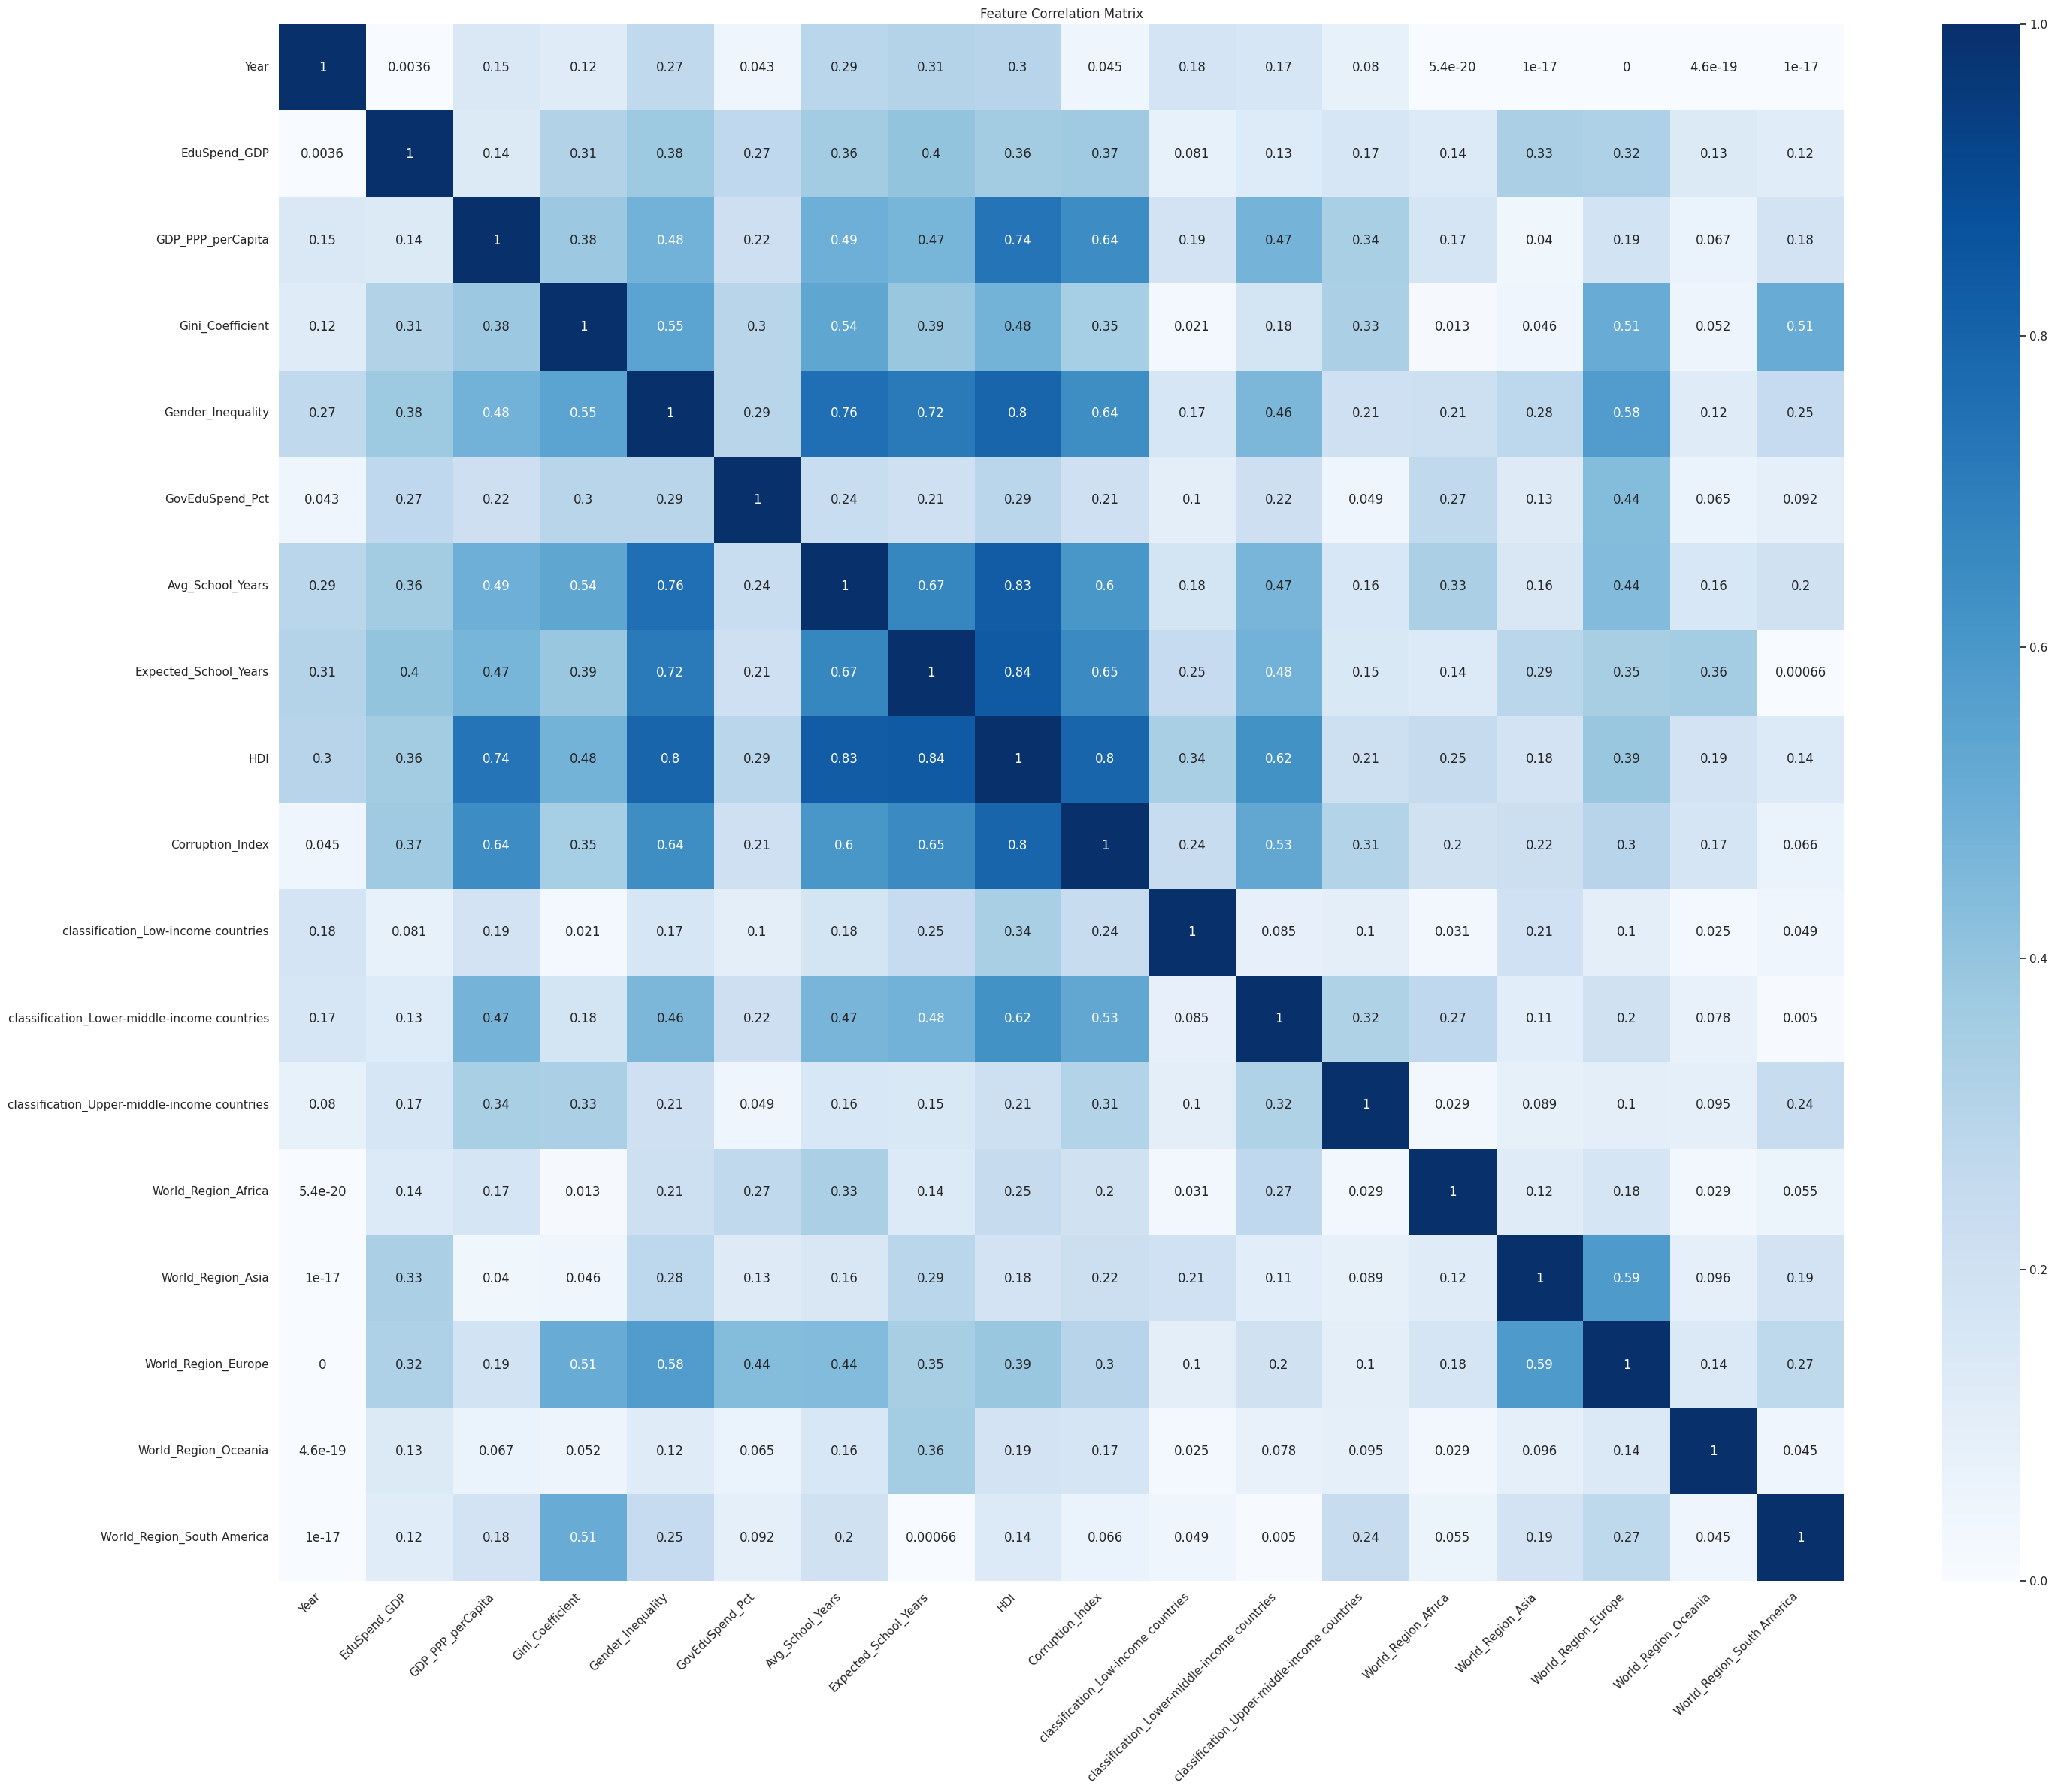

In [125]:
import seaborn as sns

# color palette to make both +1 and -1 correlation red, 0 white
# it is to see correlation more clearly by looking at the darkness regardless of them being positive or negative correlation

corr = X.corr().abs() # converted to absolute value to have higher correlations (negative or positive) more visible

plt.figure(figsize=(30, 24))

sns.heatmap(
    corr,
    annot=True,
    xticklabels=corr.columns,
    yticklabels=corr.columns,
    cmap="Blues"

)


plt.title("Feature Correlation Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks()
plt.tight_layout()

plt.show()


* Since I am looking for multicollinearity, I converted correlations to absolute value to see it more clearly from the graph.

* From the correlation matrix pairwise correlations are below 0.8 except for HDI, so they seem acceptable.

* Now I will look at VIF to see more clearly if there is multicollinarity.

In [126]:
X_multicol = X
# Calculate VIF
X = X_multicol
X = sm.add_constant(X)  # statsmodels requires adding constant manually

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

,feature,VIF
0,const,20.687475
1,Year,1.390214
2,EduSpend_GDP,2.078860
3,GDP_PPP_perCapita,3.787749
4,Gini_Coefficient,3.307665
5,Gender_Inequality,4.333217
6,GovEduSpend_Pct,1.946476
7,Avg_School_Years,6.372555
8,Expected_School_Years,6.611797
9,HDI,34.127046


* From VIF results, every other column is below 10 while HDI is quite high with 34.1.

* I tried combining with other columns but VIF was still high, best approach seems to be dropping HDI column that is why I will drop and calculate VIF again.

In [127]:
X_multicol = X_multicol.drop(columns=[
    'HDI'
  ])

# Calculate VIF
X = X_multicol
X = sm.add_constant(X)  # statsmodels requires adding constant manually
X = X.drop(columns='const') # dropping const since it will not be usefull

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

#df_multicol.head()


,feature,VIF
0,Year,1.350047
1,EduSpend_GDP,2.052579
2,GDP_PPP_perCapita,2.539637
3,Gini_Coefficient,2.739596
4,Gender_Inequality,3.996497
5,GovEduSpend_Pct,1.874118
6,Avg_School_Years,3.315819
7,Expected_School_Years,3.711054
8,Corruption_Index,3.326665
9,classification_Low-income countries,1.772215


* VIF are all below 5, therefore checking for multicollinearity is finished here.

---


### Applying Linear Regression

In [128]:
X_multicol.head()

,Year,EduSpend_GDP,GDP_PPP_perCapita,Gini_Coefficient,Gender_Inequality,GovEduSpend_Pct,Avg_School_Years,Expected_School_Years,Corruption_Index,classification_Low-income countries,classification_Lower-middle-income countries,classification_Upper-middle-income countries,World_Region_Africa,World_Region_Asia,World_Region_Europe,World_Region_Oceania,World_Region_South America
0,-1.502837,-0.856356,-1.068267,-0.763326,0.184493,-0.607354,-0.611713,-1.734980,1.340299,0,1,0,0,0,1,0,0
1,-1.078506,-1.078962,-1.016115,-0.595039,0.078031,-0.607354,-0.526086,-1.441734,1.357391,0,1,0,0,0,1,0,0
2,-0.654176,-1.038373,-0.957632,-0.731048,-0.040955,-0.757809,-0.442518,-0.929942,1.278768,0,1,0,0,0,1,0,0
3,-0.229846,-0.832733,-0.885472,-0.824459,-0.448015,-0.665533,-0.311499,-0.579946,1.394993,0,0,1,0,0,1,0,0
4,0.194485,-0.948702,-0.847682,-0.932624,-0.416702,-0.543714,-0.064737,0.464697,1.425759,0,0,1,0,0,1,0,0


* Feature columns are displayed.

---

Validation Set MSE: 921.461
Validation Set RMSE: 30.356


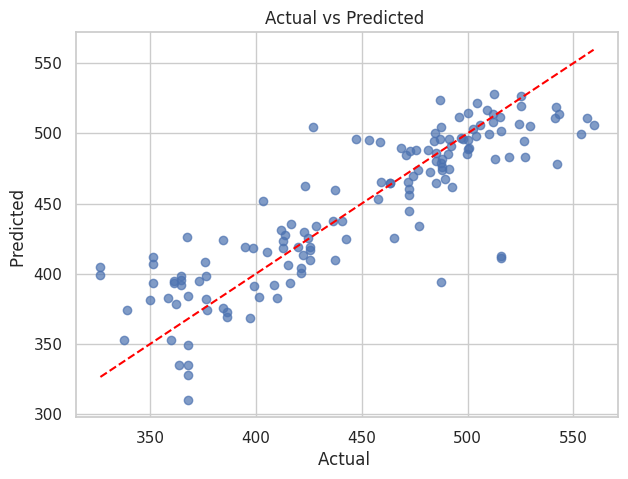

In [129]:
# updated from recitation 11 codes
X = X_multicol

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Train and evaluate
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Validation Set MSE: {mse:.3f}")
print(f"Validation Set RMSE: {mse**0.5:.3f}")



# Plot actual vs predicted scores
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.xlabel('Actual ')
plt.ylabel('Predicted ')
plt.title('Actual vs Predicted ')
plt.grid(True)
plt.show()

In [130]:
# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=55)
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')

# Convert negative MSE to positive
cv_mse_scores = -cv_scores

print("5-Fold CV MSE Scores:", cv_mse_scores)
print(f"Average CV MSE: {cv_mse_scores.mean():.3f}")
rmse = cv_mse_scores.mean()**0.5
print(f"Average CV RMSE: {rmse:.3f}")

5-Fold CV MSE Scores: [725.20047349 783.2626578  756.4033962  920.05433703 781.61367961]
Average CV MSE: 793.307
Average CV RMSE: 28.166
